In [167]:
import os
import sys
project_name = 'ai_synth'
src_dir_relative_path = '../../../src'
if src_dir_relative_path not in sys.path:
    sys.path.append(src_dir_relative_path)

from pathlib import Path
from torchaudio.transforms import Spectrogram, AmplitudeToDB
from model.loss import spectral_loss
from synth.synth_architecture import SynthModular
from main_hp_search_dec_only import configure_experiment
from dataset.ai_synth_dataset import AiSynthDataset
from synth.synth_constants import synth_constants
from utils.visualization_utils import  calc_loss_vs_param_range, plot_loss_vs_param
from utils.train_utils import to_torch_recursive

import matplotlib
matplotlib.pyplot.ion()

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

notebook_path = Path('.').resolve()
dir_list = notebook_path.parts
root_index = dir_list.index(project_name)
abs_path = Path(*dir_list[:root_index+1])

project_root = abs_path

In [168]:
# Setup experiment

exp_name = 'loss_surface_visualization_fm_saw'
dataset_name = 'lfo_saw_single'
device = 'cpu'

config_path = os.path.join(project_root, 'configs', 'optimization_analysis', 'lfo_saw_single_synth_config_hp_search.yaml')
data_path = os.path.join(project_root, 'data', dataset_name, 'train', '')

cfg = configure_experiment(exp_name, dataset_name, config_path, debug=True)

synth = SynthModular(preset_name=cfg.synth.preset,
                     synth_constants=synth_constants,
                     device=device)

dataset = AiSynthDataset(data_path, noise_std=0)

Deleting previous experiment...


In [169]:
target_sample = dataset[12]
target_signal, target_param_dict, signal_index = target_sample

target_param_dict = to_torch_recursive(target_param_dict, device, ignore_dtypes=(str, tuple))

target_signal = target_signal.to(device)

synth.update_cells_from_dict(target_param_dict)
print(target_param_dict)

{(1, 1): {'operation': 'lfo', 'parameters': {'active': tensor([True]), 'output': tensor([[0, 2]]), 'freq': tensor([11.6572]), 'waveform': 'square'}}, (0, 2): {'operation': 'fm_saw', 'parameters': {'fm_active': tensor([1], dtype=torch.int32), 'active': tensor([True]), 'amp_c': tensor([0.3279]), 'freq_c': tensor([207.6523]), 'mod_index': tensor([0.0269])}}}


In [170]:
cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset=cfg.loss.preset,
                                          synth_constants=synth_constants,
                                          device=device)

In [171]:
params_to_visualize = [{'param_name': 'freq_c', 'cell_index': (0, 2), 'min_val': 0, 'max_val': 2000, 'n_steps': 2000},
                       {'param_name': 'amp_c', 'cell_index': (0, 2), 'min_val': 0, 'max_val': 1, 'n_steps': 1000},
                       {'param_name': 'mod_index', 'cell_index': (0, 2), 'min_val': 0, 'max_val': 0.3, 'n_steps': 300},
                       {'param_name': 'freq', 'cell_index': (1, 1), 'min_val': 0, 'max_val': 20, 'n_steps': 1000}]

In [172]:
import numpy as np
from scipy.signal import argrelmin

def get_num_of_local_min(func):
    func = np.array(func)
    # Find the indices of the local minima
    indices = argrelmin(func)[0]
    num_minima = len(indices)

    print("Number of local minima:", num_minima)
    return num_minima

import numpy as np


def get_num_of_non_convex_regions(func: list, region_len: int) -> int:

    # Generate the corresponding x values
    x = np.arange(len(func))

    # Initialize a counter for the number of non-convex regions
    num_non_convex_regions = 0

    # Loop over the regions
    iterator = range(0, len(func), region_len)
    for i in iterator:
        # Fit a cubic spline to the function values in the current region
        spline = np.polyfit(x[i:i+region_len], func[i:i+region_len], 3)

        # Evaluate the second derivative of the spline at the first and last points in the region
        x0 = i
        x1 = i + region_len - 1
        second_derivative_at_x0 = 2 * spline[0]
        second_derivative_at_x1 = 2 * spline[0]

        # Check if the function is non-convex in the current region
        if second_derivative_at_x0 < 0 or second_derivative_at_x1 < 0:
            num_non_convex_regions += 1

    # Print the number of non-convex regions
    print("Number of non-convex regions:", num_non_convex_regions)
    print(f"Total amount of {region_len}regions:", len(iterator))
    return num_non_convex_regions

def get_percentage_of_convex_regions(func: list, region_len: int) -> int:

    # Generate the corresponding x values
    x = np.arange(len(func))

    # Initialize a counter for the number of convex regions
    num_convex_regions = 0

    # Loop over the regions
    for i in range(0, len(func), region_len):
        # Fit a cubic spline to the function values in the current region
        spline = np.polyfit(x[i:i+region_len], func[i:i+region_len], 3)

        # Evaluate the second derivative of the spline at the first and last points in the region
        x0 = i
        x1 = i + region_len - 1
        second_derivative_at_x0 = 2 * spline[0]
        second_derivative_at_x1 = 2 * spline[0]

        # Check if the function is convex in the current region
        if second_derivative_at_x0 > 0 and second_derivative_at_x1 > 0:
            num_convex_regions += 1

    # Calculate the percentage of the function that is convex
    num_regions = len(func) // region_len
    percentage_convex = 100 * num_convex_regions / num_regions

    # Print the percentage of the function that is convex
    print("Percentage of the function that is convex: {:.1f}%".format(percentage_convex))
    return percentage_convex




100%|██████████| 2000/2000 [00:16<00:00, 118.21it/s]


Number of local minima: 337
Number of non-convex regions: 11
Total amount of 100regions: 20
Percentage of the function that is convex: 48.8%


100%|██████████| 1000/1000 [00:10<00:00, 95.07it/s]


Number of local minima: 1
Number of non-convex regions: 8
Total amount of 100regions: 10
Percentage of the function that is convex: 53.0%


100%|██████████| 300/300 [00:03<00:00, 95.09it/s] 


Number of local minima: 33
Number of non-convex regions: 3
Total amount of 100regions: 3
Percentage of the function that is convex: 56.7%


100%|██████████| 1000/1000 [00:10<00:00, 96.87it/s]


Number of local minima: 262
Number of non-convex regions: 5
Total amount of 100regions: 10
Percentage of the function that is convex: 52.0%


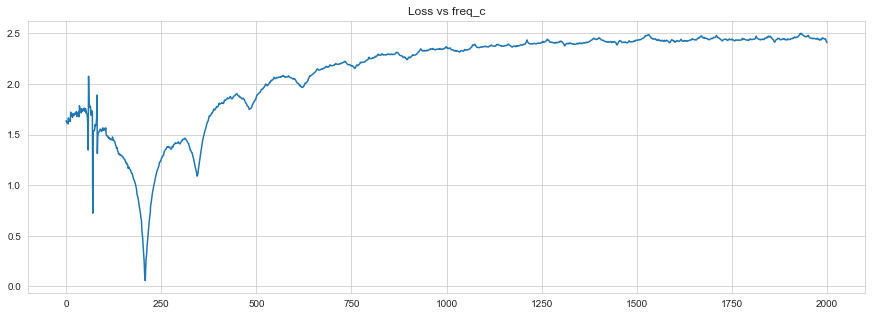

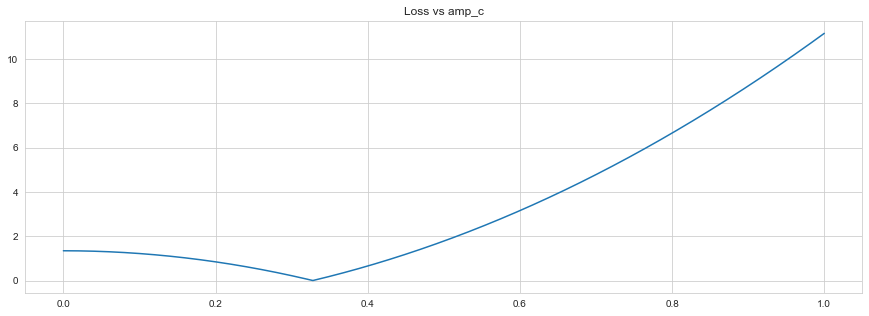

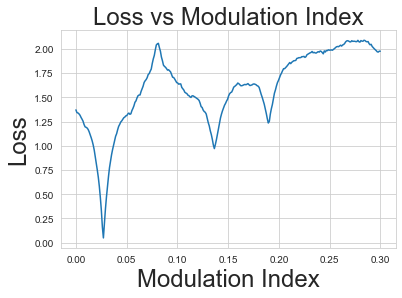

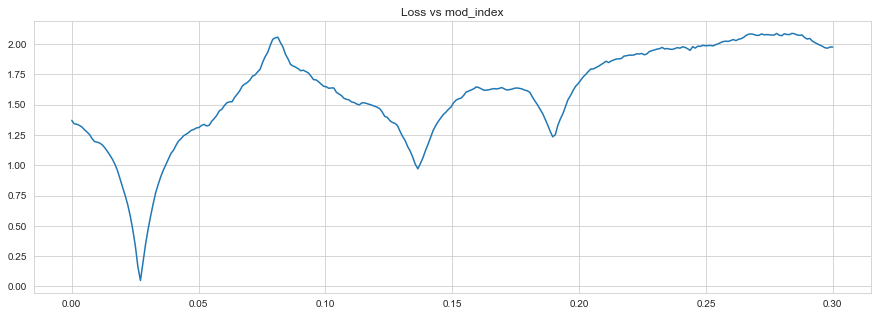

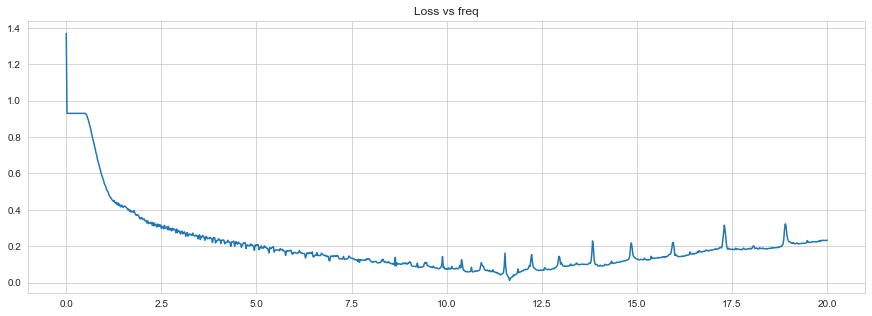

In [177]:
for param_to_visualize in params_to_visualize:

    loss_vals, param_range = calc_loss_vs_param_range(synth, target_param_dict, target_signal, loss_handler, **param_to_visualize)
    if param_to_visualize["param_name"] == 'mod_index':
        fig_size = (6, 4)  # Set the size of the figure
        font_size = 24    # Set the font size for title and axis labels

        # Generate your plot
        fig = plt.figure(figsize=fig_size)
        ax = fig.gca()
        ax.plot(param_range, loss_vals)
        ax.set_title('Loss vs Modulation Index', fontsize=font_size)
        ax.set_xlabel('Modulation Index', fontsize=font_size)
        ax.set_ylabel('Loss', fontsize=font_size)

        # Save the plot to a file
        plt.savefig(r"C:\Users\noamk\PycharmProjects\ai_synth\loss_vs_modulation_index.png", dpi=300, bbox_inches='tight')

    plot_loss_vs_param(param_range, loss_vals, title=f'Loss vs {param_to_visualize["param_name"]}')
    get_num_of_local_min(loss_vals)
    get_num_of_non_convex_regions(loss_vals, region_len=100)
    get_percentage_of_convex_regions(loss_vals, region_len=5)

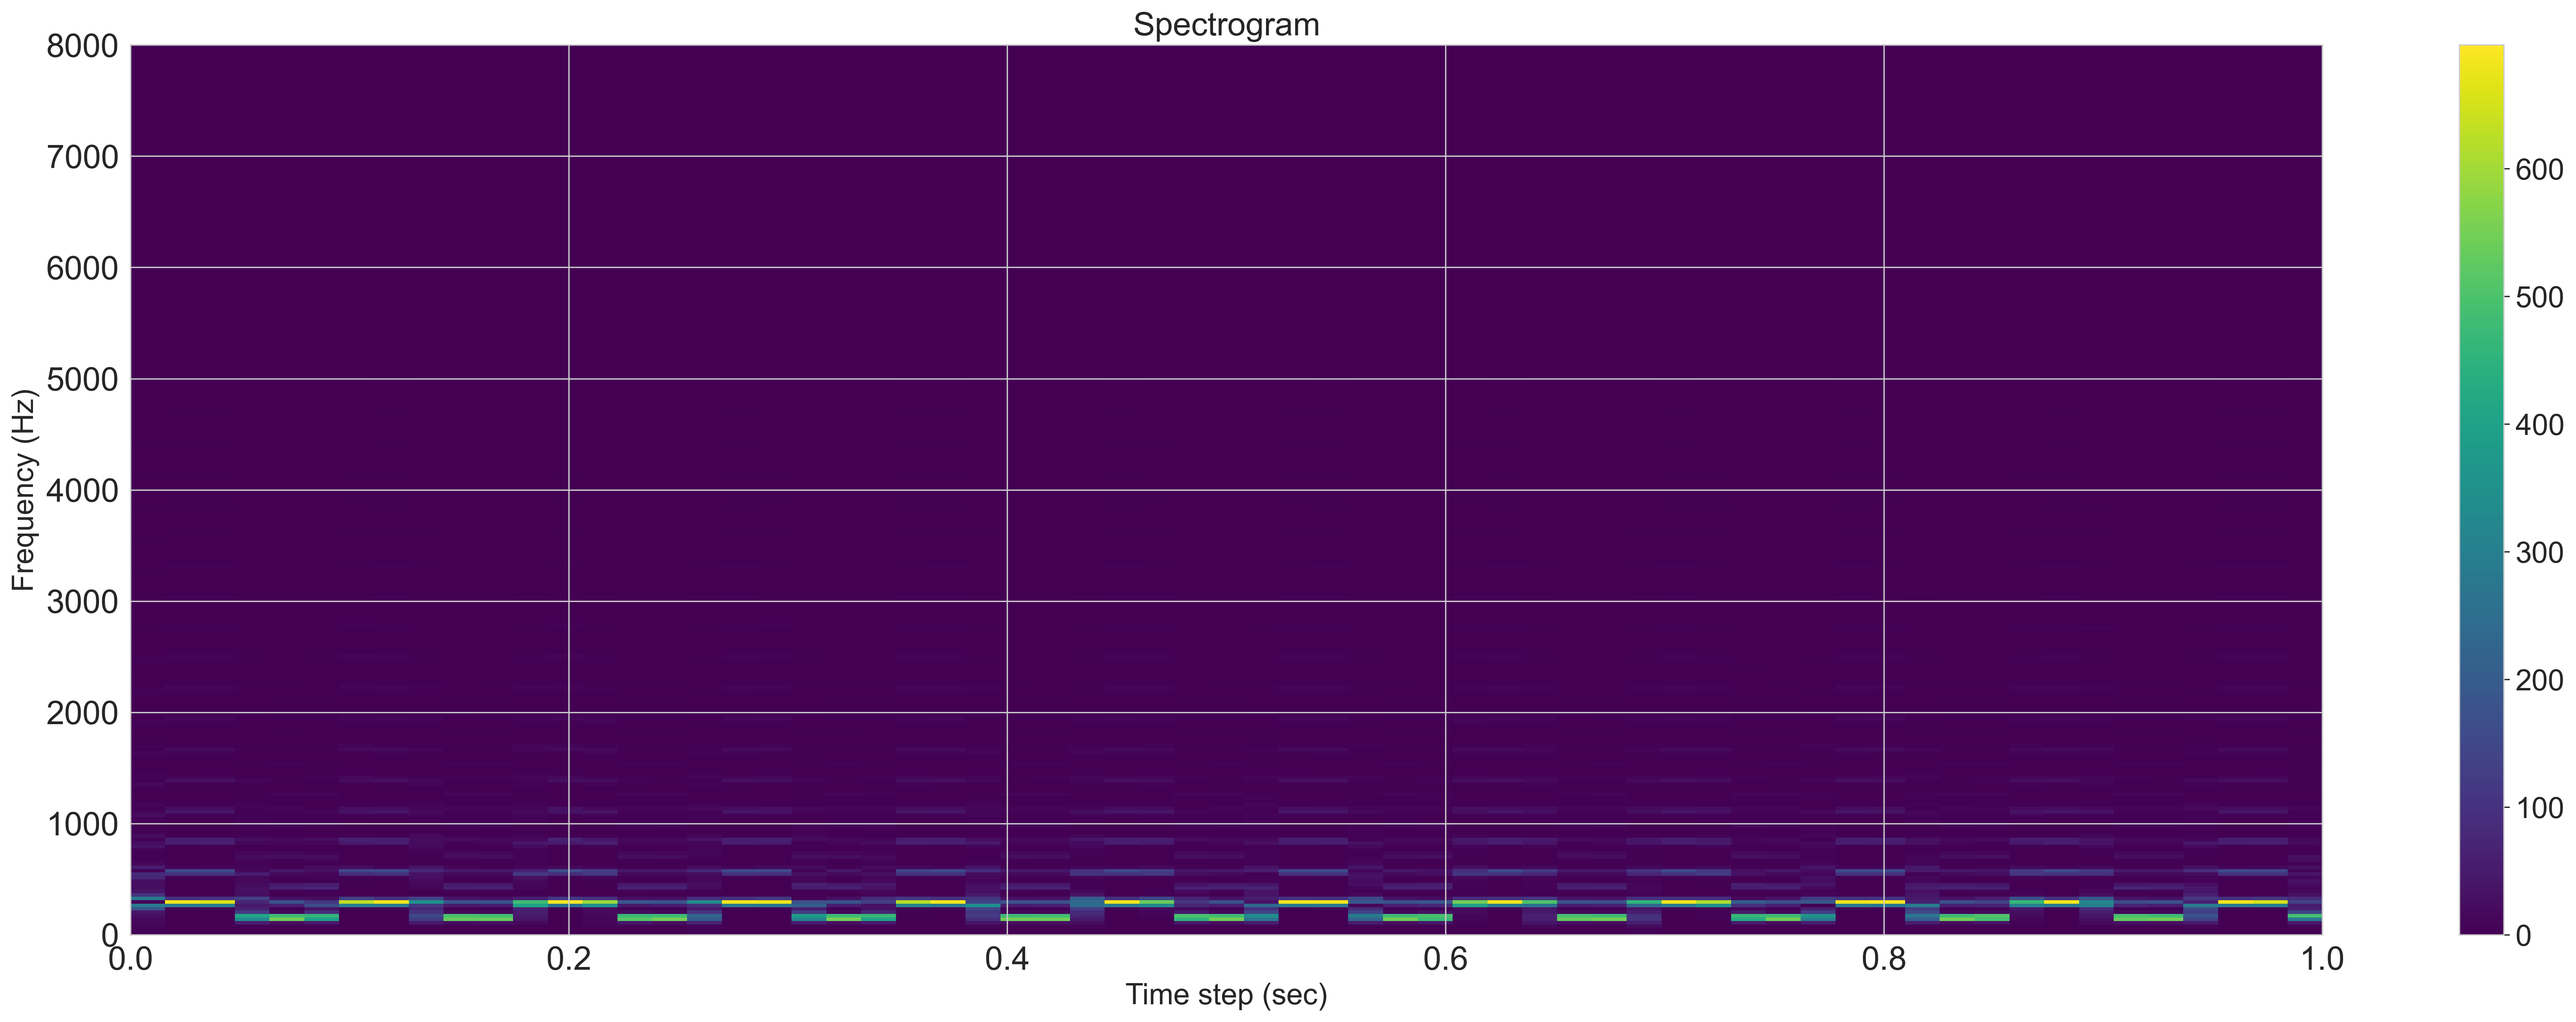

In [174]:
sample_rate = 16000
n_fft = 512
spec_op = Spectrogram(n_fft=n_fft, power=2.0, pad_mode='reflect')
db = AmplitudeToDB()

plt.figure(figsize=(30, 10))
plt.gcf().set_dpi(300)
target_spec = spec_op(target_signal.cpu())

plt.imshow(target_spec.squeeze(), origin='lower', aspect='auto', cmap='viridis', extent=[0, 1, 0, sample_rate/2])

plt.title('Spectrogram', fontsize=20)
plt.ylabel('Frequency (Hz)', fontsize=18)
plt.xlabel('Time step (sec)', fontsize=18)
plt.tick_params(labelsize=20)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=18)

plt.show()
